In [139]:
from PIL import Image, ImageDraw
import os
import numpy as np
import cv2
from numpy import asarray

Crop image

In [140]:
# Opens a image in RGB mode
__current_folder = os.path.join(os.getcwd(), "")
__current_image = os.path.join(__current_folder, r"sun_wb.jpg")
original_image = Image.open(__current_image).convert("RGB")

# Cropped image of above dimension
__cropped_image = os.path.join(__current_folder, r"sun_cropped_image.png")
cropped_image = original_image.crop((174, 174, 1876, 1876)) # left top right bottom
cropped_image.save(__cropped_image)

Create a circle image with alpha chanel

In [141]:
# Get params of the cropped image
height, weight = cropped_image.size

# Create same size alpha layer with circle
alpha = Image.new('L', cropped_image.size, 0)
draw = ImageDraw.Draw(alpha)
draw.pieslice([0, 0, height, weight], 0, 360, fill=255)

# Convert alpha Image to numpy array and add alpha layer to RGB
__circle_cropped_image = os.path.join(__current_folder, r"sun_circle_cropped_image.png")
circle_cropped_image = Image.fromarray(np.dstack((np.array(cropped_image), np.array(alpha))))
circle_cropped_image.save(__circle_cropped_image)

Image processing and preparation

In [142]:
# Load circle cropped image by OpenCV
image = cv2.imread(__circle_cropped_image, cv2.IMREAD_UNCHANGED)

# Make mask with transparent bits
transparent_mask = image[:, :, 3] == 0

# Replace areas of transparency with white
image[transparent_mask] = [255, 255, 255, 255]

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Add blur
blur = cv2.GaussianBlur(gray, (0,0), sigmaX=33, sigmaY=33)

# Divide
divide = cv2.divide(gray, blur, scale=255)

# Threshold
thresh = cv2.threshold(divide, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# Apply morphology
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

Detecting sunspots

Number of sunspots is 34


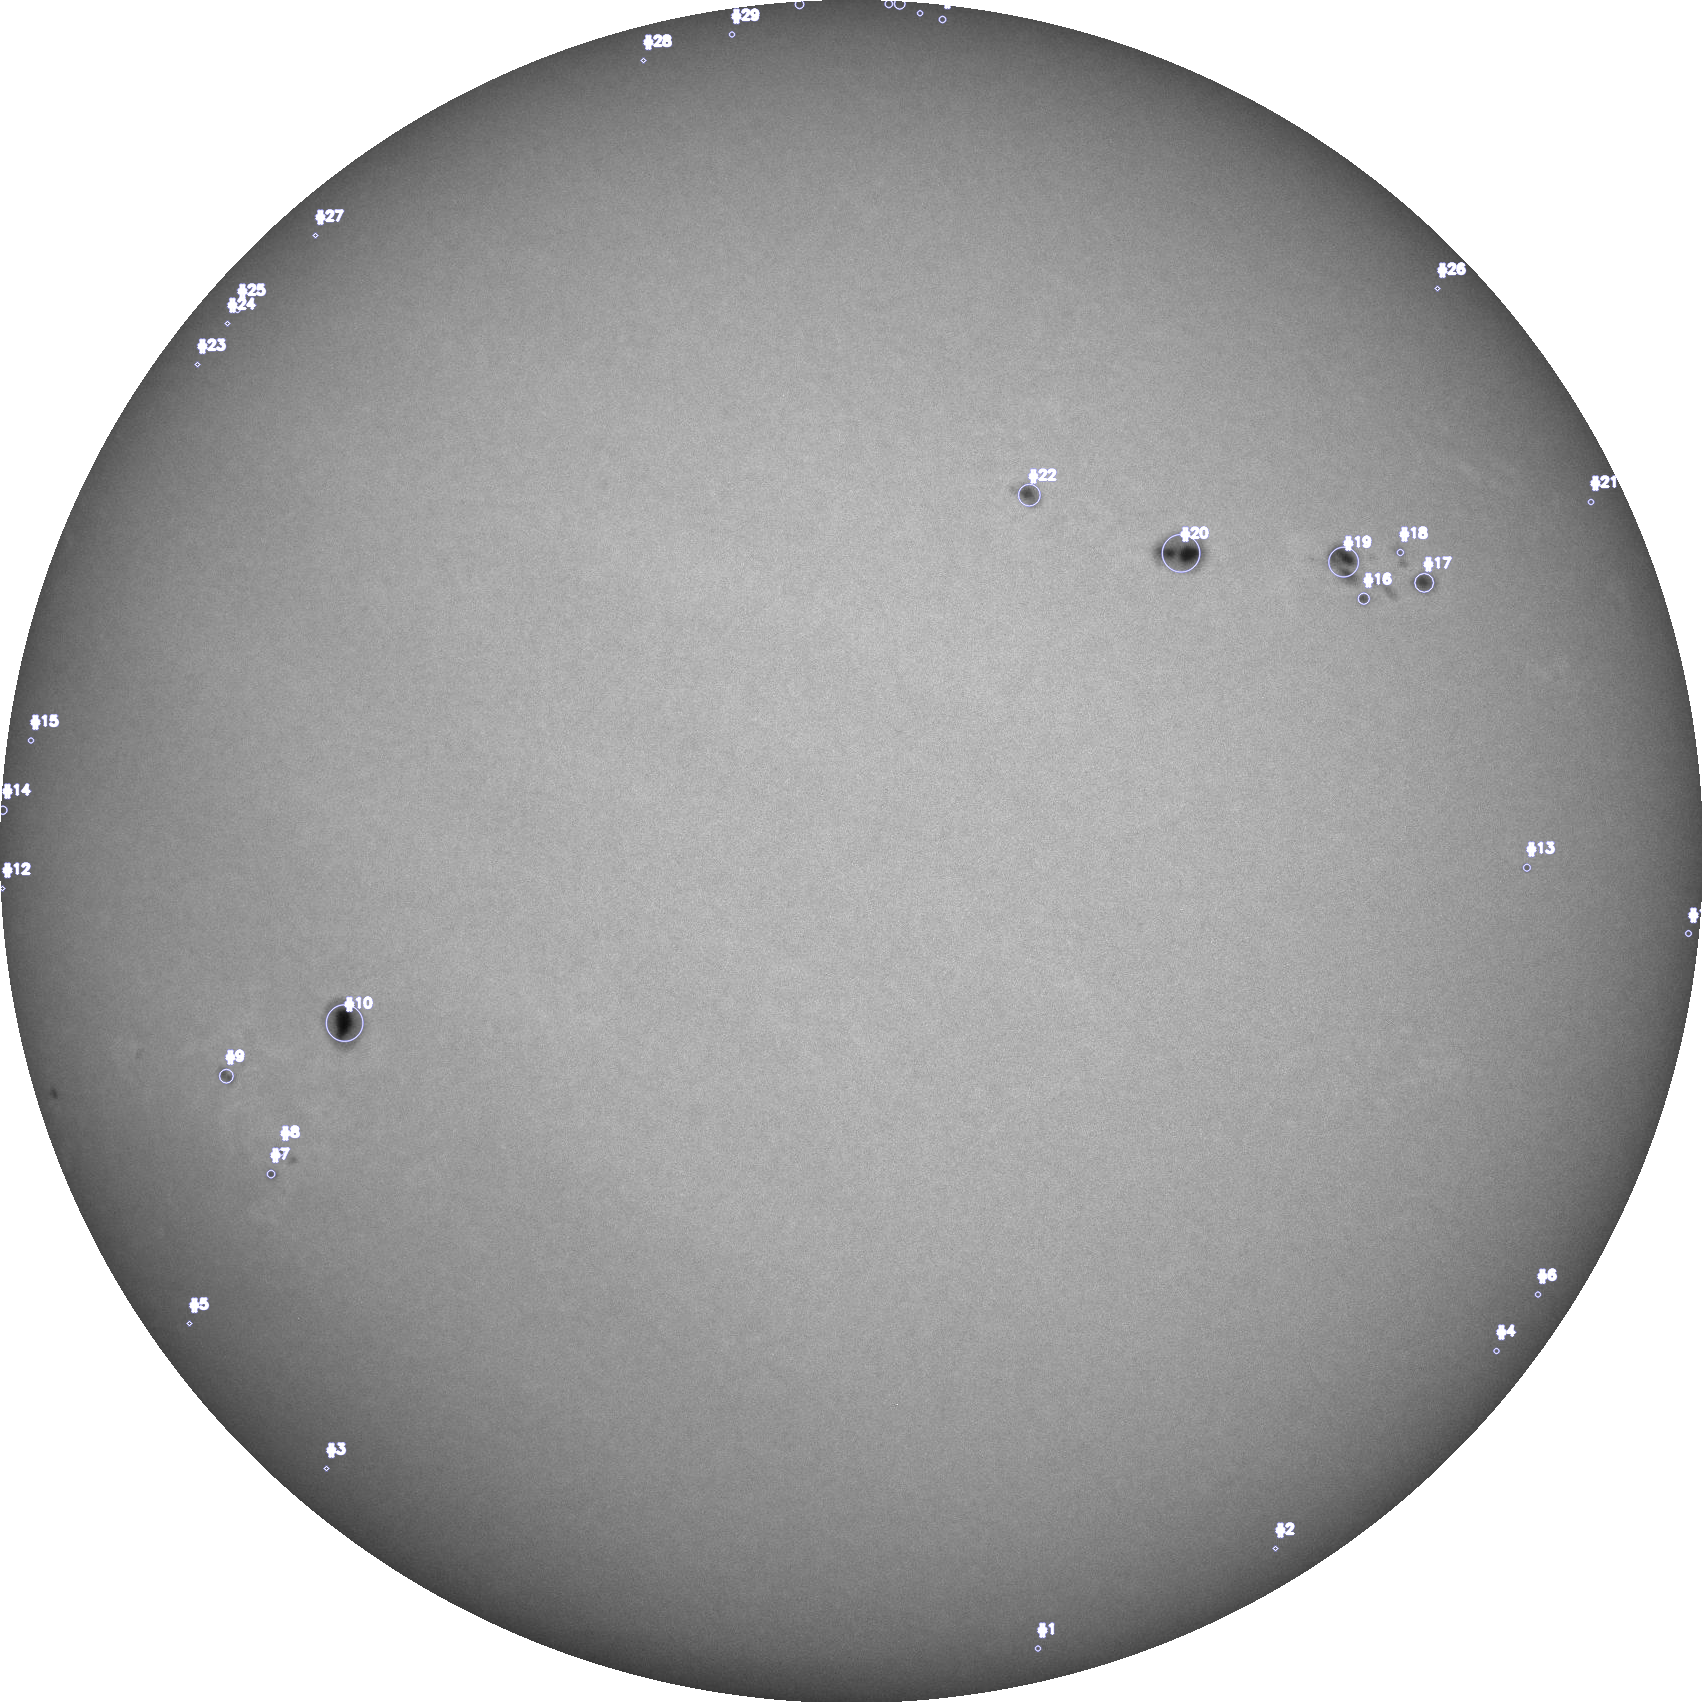

In [143]:
# Setup the blob detector with parameters.
params = cv2.SimpleBlobDetector_Params()
params.minArea = 5
params.maxArea = 200
params.filterByConvexity = False
params.filterByInertia = False
params.filterByArea = False
params.filterByCircularity = False

# Create detector
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs
keypoints = detector.detect(morph)

# Draw detected blobs as circles
result_image = cv2.drawKeypoints(asarray(circle_cropped_image).copy(), keypoints, -1, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# loop over the contours
for i in range(0, len(keypoints)):
    (x, y) = keypoints[i].pt
    cv2.putText(result_image, "#{}".format(i + 1), (int(x), int(y) - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2, cv2.LINE_AA)

# Save result
__result_image = os.path.join(__current_folder, r"sun_result.png")
Image.fromarray(result_image).save(__result_image)

# Print number of sunspots
print("The number of sunspots is {}".format(len(keypoints)))

# Show the image
Image.fromarray(result_image)